In [81]:
# Packages
import psycopg2
from psycopg2 import OperationalError
from psycopg2 import sql

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from datetime import datetime, timedelta

import os
from dotenv import load_dotenv
dotenv_path = os.path.expanduser('~/.pwds.env')
load_dotenv(dotenv_path)



# Conexão à base de dados
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')


conn = psycopg2.connect(
                host = db_host,
                port = db_port,
                user = db_user,
                password = db_password
        )

import os
os.chdir("/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens")

# Flag R031 

## Organização das células soltas sobre esta flag

**1. Filtrar contratos : ID's concursos públicos com CPV's começados por 72**

In [2]:
cur = conn.cursor()
cur.execute('''
            SELECT id, preco_contratual, anuncio_preco_base
            FROM contratos_basegov
            WHERE SUBSTRING(contratos_basegov."cpv", 1, 2) = '72'
                 AND tipo_procedimento = 'Concurso público'
            ORDER BY data_publicacao DESC;''')

cpub = pd.DataFrame(cur.fetchall())

In [3]:
cpub = cpub.rename(columns={0:'ID',1:'PrecoContratual',2:'PrecoBase'})

In [4]:
cpub.head()

,ID,PrecoContratual,PrecoBase
0,10784770,36558.00,7121877.93
1,10783176,16030.00,16030.00
2,10783293,170000.00,170000.00
3,10783671,64310.40,64680.00
4,10779217,91000.08,96000.00


**2. Número de concursos públicos com preco base nulo**

In [76]:
cur = conn.cursor()
cur.execute('''
            SELECT COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' AND ( contratos_basegov."anuncio_preco_base" IS NULL OR anuncio_preco_base = 0 )
            ;''')

cur.fetchone()[0]

3517

In [87]:
cur = conn.cursor()
cur.execute('''
            SELECT COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' AND anuncio_preco_base = 0 
            ;''')

cur.fetchone()[0]

20

In [88]:
cur = conn.cursor()
cur.execute('''
            SELECT COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' AND anuncio_preco_base IS NULL 
            ;''')

cur.fetchone()[0]

3497

In [90]:
3597/130099*100

2.764817562010469

**3. Número de concursos públicos com preco contratual nulo**

In [77]:
cur = conn.cursor()
cur.execute('''
        SELECT COUNT(*)
        FROM contratos_basegov
        WHERE tipo_procedimento = 'Concurso público' AND (contratos_basegov."preco_contratual" IS NULL OR preco_contratual = 0);''')

cur.fetchone()[0]

1647

**4. Número de concursos cujo preço contratual é superior ao preço base**

In [78]:
cur = conn.cursor()
cur.execute('''
            SELECT COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público'  
                    AND anuncio_preco_base IS NOT NULL 
                    AND anuncio_preco_base > 0
                    AND preco_contratual > 0
                    AND preco_contratual > anuncio_preco_base;
            ''')

cur.fetchone()[0]

348

**5. Exclusão dos contratos com lotes. Selecionam-se concursos públicos com numero de anuncio unico**

In [8]:
cur = conn.cursor()
cur.execute('''
            SELECT id
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' AND
                    n_anuncio IN (
                            SELECT n_anuncio
                            FROM contratos_basegov
                            GROUP BY n_anuncio
                            HAVING COUNT(DISTINCT n_anuncio) = 1
            );
            ''')

cur.fetchall()[0]

(7750353,)

**6. Selecionar concursos públicos com número de anúncio único cujo preço base se encontra 10\% em torno no preço base**

In [79]:
cur = conn.cursor()
cur.execute('''
            SELECT COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' 
                    AND anuncio_preco_base IS NOT NULL 
                    AND anuncio_preco_base > 0
                    AND preco_contratual > 0
                    AND preco_contratual > anuncio_preco_base * (1 - 0.1) 
                    AND n_anuncio IN (
                            SELECT n_anuncio
                            FROM contratos_basegov
                            GROUP BY n_anuncio
                            HAVING COUNT(DISTINCT n_anuncio) = 1
            );
            ''')

cur.fetchall()

[(35967,)]

<p style="font-size: 20px;">Condições a incluir para ativar a flag:</p>

1. Preço base é  nulo
2. Preço contratual é superior ao preço base ( neste caso não pode ser nulo )
3. Preço contratual encontra-se muito perto do preço base ( neste caso não pode ser nulo )

In [82]:
cur = conn.cursor()
cur.execute('''
            SELECT id
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' AND 
                    (
                    (anuncio_preco_base IS NOT NULL AND anuncio_preco_base > 0 AND preco_contratual > 0 AND preco_contratual > anuncio_preco_base) 
                    OR
                    (anuncio_preco_base IS NULL OR anuncio_preco_base = 0) 
                    OR
                    (anuncio_preco_base IS NOT NULL AND anuncio_preco_base > 0 AND preco_contratual > 0 AND preco_contratual > anuncio_preco_base * (1 - 0.1))
                    ) 
                    AND n_anuncio IN (
                        SELECT n_anuncio
                        FROM contratos_basegov
                        GROUP BY n_anuncio
                        HAVING COUNT(DISTINCT n_anuncio) = 1
                        );
            ''')

cur.fetchall()

[(5178941,),
 (5178904,),
 (5178855,),
 (5178697,),
 (5177872,),
 (5185212,),
 (5185150,),
 (5184979,),
 (5184971,),
 (5184854,),
 (5184776,),
 (5184363,),
 (5184260,),
 (5183694,),
 (5183545,),
 (5183533,),
 (5183482,),
 (5182394,),
 (5182287,),
 (5182205,),
 (5187721,),
 (5187638,),
 (5191275,),
 (5191248,),
 (5191167,),
 (5201222,),
 (10442307,),
 (10442177,),
 (10442056,),
 (10442044,),
 (10442009,),
 (5200623,),
 (5200550,),
 (5200461,),
 (10441677,),
 (5200049,),
 (10441559,),
 (5199737,),
 (10441447,),
 (10441431,),
 (10441275,),
 (5206060,),
 (10441067,),
 (10441014,),
 (5205619,),
 (5205582,),
 (10440555,),
 (5205293,),
 (10440369,),
 (10440324,),
 (10440280,),
 (5205154,),
 (5205112,),
 (10440102,),
 (10440072,),
 (5204795,),
 (5204773,),
 (10439973,),
 (10439967,),
 (5204327,),
 (10439784,),
 (10439773,),
 (5204070,),
 (5203873,),
 (10439472,),
 (10439456,),
 (10439277,),
 (10439096,),
 (10439064,),
 (10439012,),
 (10439004,),
 (10438939,),
 (10438863,),
 (10438853,),
 (1043

**Distribuição de preços contratuais superiores a preços base por divisão de CPV**

In [83]:
cur = conn.cursor()

cur.execute('''
            SELECT SUBSTRING(contratos_basegov."cpv", 1, 2) as cpv2, COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público'
                  AND anuncio_preco_base IS NOT NULL 
                  AND anuncio_preco_base > 0
                  AND preco_contratual > 0
                  AND preco_contratual > anuncio_preco_base
            GROUP BY cpv2
            HAVING COUNT(*) > 10
            ORDER BY COUNT(*) DESC;
            ''')

r31 = pd.DataFrame(cur.fetchall())

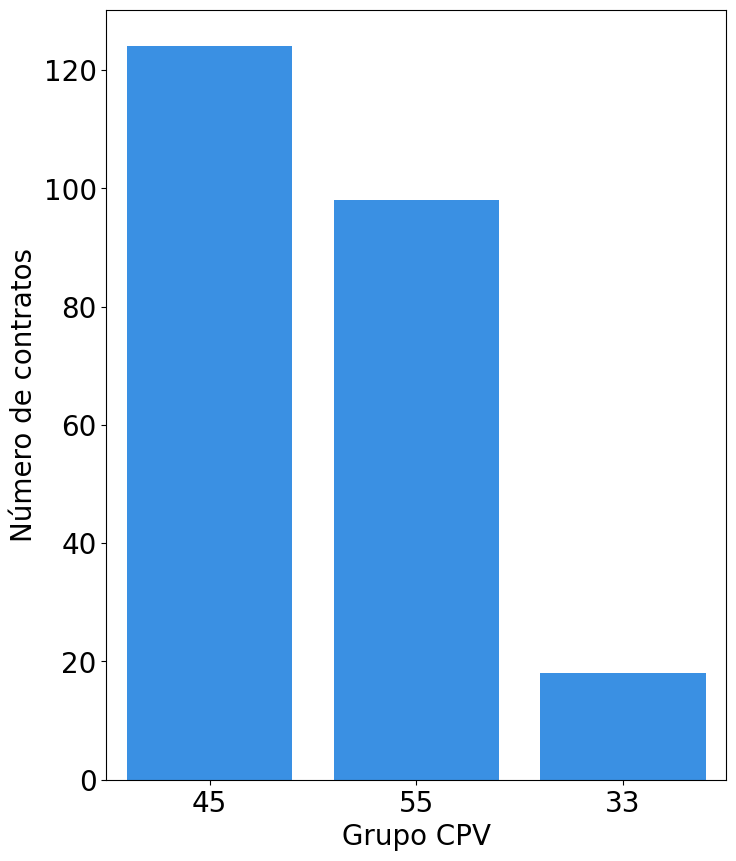

In [84]:
f, ax = plt.subplots(figsize=(8,10))
sns.barplot(x = r31.columns[0], y = r31.columns[1], data = r31, orient = 'v', color="dodgerblue")

ax.tick_params(axis='x')
ax.set_ylabel('Número de contratos', fontsize = 20)
ax.set_xlabel('Grupo CPV', fontsize = 20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.savefig("r31/pcpb.png", dpi = 500, bbox_inches='tight')

plt.show()

**Distribuição de preços base nulos por divisão de CPV**

In [70]:
cur = conn.cursor()

cur.execute('''
            SELECT SUBSTRING(contratos_basegov."cpv", 1, 2) as cpv2, COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' AND (anuncio_preco_base IS NULL OR anuncio_preco_base = 0)
            GROUP BY cpv2
            HAVING COUNT(*) > 150
            ORDER BY COUNT(*) DESC;
            ''')

r31_v1 = pd.DataFrame(cur.fetchall())

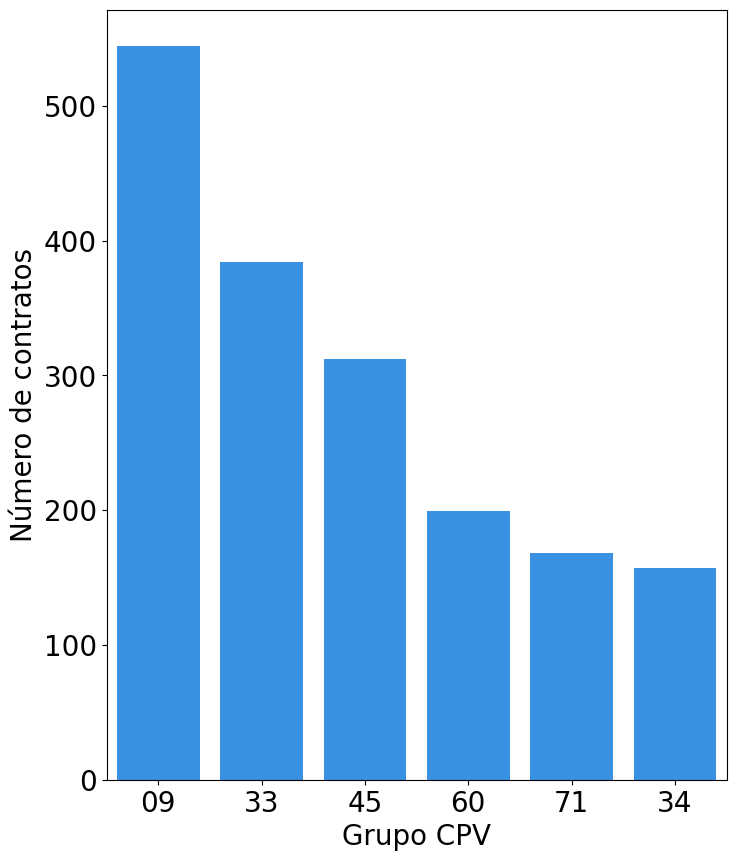

In [71]:
f, ax = plt.subplots(figsize=(8,10))
sns.barplot(x = r31_v1.columns[0], y = r31_v1.columns[1], data = r31_v1, orient = 'v', color="dodgerblue")

ax.tick_params(axis='x')
ax.set_ylabel('Número de contratos', fontsize = 20)
ax.set_xlabel('Grupo CPV', fontsize = 20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.savefig("r31/pb.png", dpi = 500, bbox_inches='tight')

plt.show()

**Distribuição de contratos com preço contratual muito perto do preço base**

In [85]:
cur = conn.cursor()
cur.execute('''
            SELECT SUBSTRING(contratos_basegov."cpv", 1, 2) as cpv2, COUNT(*)
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' 
                    AND anuncio_preco_base IS NOT NULL 
                    AND anuncio_preco_base > 0 
                    AND preco_contratual > 0
                    AND preco_contratual > anuncio_preco_base * (1 - 0.1) 
                    AND n_anuncio IN (
                        SELECT n_anuncio
                        FROM contratos_basegov
                        GROUP BY n_anuncio
                        HAVING COUNT(DISTINCT n_anuncio) = 1)
            GROUP BY cpv2
            HAVING COUNT(*) > 1500
            ORDER BY COUNT(*) DESC;
            ''')

r31_v2 = pd.DataFrame(cur.fetchall())

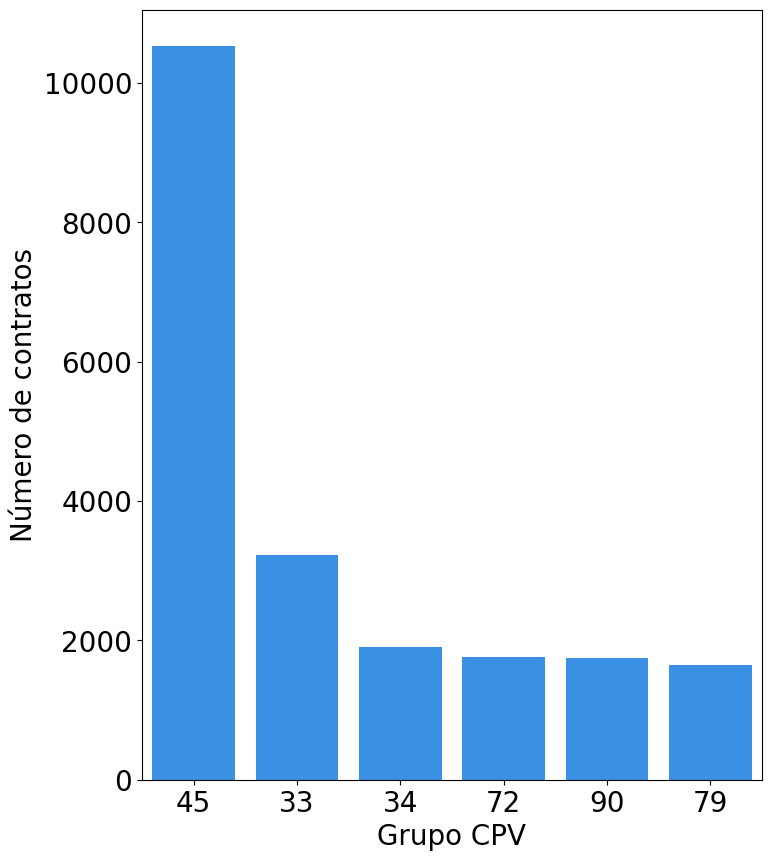

In [86]:
f, ax = plt.subplots(figsize=(8,10))
sns.barplot(x = r31_v2.columns[0], y = r31_v2.columns[1], data = r31_v2, orient = 'v', color="dodgerblue")

ax.tick_params(axis='x')
ax.set_ylabel('Número de contratos', fontsize = 20)
ax.set_xlabel('Grupo CPV', fontsize = 20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.savefig("r31/pcpbnear.png", dpi = 500, bbox_inches='tight')

plt.show()

In [67]:
cur = conn.cursor()
cur.execute('''
            SELECT preco_contratual / anuncio_preco_base
            FROM contratos_basegov
            WHERE tipo_procedimento = 'Concurso público' 
                    AND anuncio_preco_base IS NOT NULL 
                    AND anuncio_preco_base > 0 
                    AND preco_contratual < anuncio_preco_base 
                    AND preco_contratual > anuncio_preco_base * (1 - 0.1) 
                    AND n_anuncio IN (
                            SELECT n_anuncio
                            FROM contratos_basegov
                            GROUP BY n_anuncio
                            HAVING COUNT(DISTINCT n_anuncio) = 1
            );
            ''')

cur.fetchall()

[(0.970538888888889,),
 (0.9893724696356275,),
 (0.9750549009154533,),
 (0.9917400614035087,),
 (0.9882484848484848,),
 (0.9997929324240545,),
 (0.98,),
 (0.9433679591836734,),
 (0.964987012987013,),
 (0.9938894205992785,),
 (0.9903903441191576,),
 (0.988955806058107,),
 (0.9846663981042654,),
 (0.9999014513271346,),
 (0.9927692307692307,),
 (0.999910289098279,),
 (0.9913679479227057,),
 (0.9998639024390245,),
 (0.9999121212121213,),
 (0.94725,),
 (0.98035825988058,),
 (0.9337084545454545,),
 (0.9994314666666667,),
 (0.9953038965714811,),
 (0.9941488,),
 (0.9291176470588235,),
 (0.9485714285714286,),
 (0.9986539523228369,),
 (0.9793762575452716,),
 (0.9760089189189188,),
 (0.9817835115864528,),
 (0.9939913422683362,),
 (0.951768228061591,),
 (0.9860038098963205,),
 (0.972972797662559,),
 (0.9987586349206349,),
 (0.983265197298258,),
 (0.9935111245801449,),
 (0.9382935009797518,),
 (0.9987951807228915,),
 (0.9987597503100625,),
 (0.9996565802537645,),
 (0.9890929847046239,),
 (0.9797093

In [92]:
def flagr31(tol):
    """
    Parâmetro de entrada:
        tol(float): número entre 0 e 1

    return: tuplo de IDs que respeitam as condições impostas
    """

    cur = conn.cursor()
    cur.execute('''
                SELECT id
                FROM contratos_basegov
                WHERE tipo_procedimento = 'Concurso público' 
                        AND anuncio_preco_base IS NOT NULL 
                        AND anuncio_preco_base > 0 
                        AND preco_contratual < anuncio_preco_base 
                        AND preco_contratual > anuncio_preco_base * (1 - %s) 
                        AND n_anuncio IN (
                                SELECT n_anuncio
                                FROM contratos_basegov
                                GROUP BY n_anuncio
                                HAVING COUNT(DISTINCT n_anuncio) = 1
                );
                ''', (tol,))
    
    return(cur.fetchall())

flagr31(0.1)

[(27482,)]

In [100]:
39832/130099*100

30.616684217403666

In [99]:
3517+35967+348

39832